In [45]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os, os.path
import pickle
import numpy
from scipy import interpolate
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
%pylab inline
from matplotlib import cm
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [2]:
pos_radec, rvel_ra= pal5_util.pal5_data()

## Some convenience functions

In [3]:
def width_trailing(sdf):
    """Return the FWHM width in arcmin for the trailing tail"""
    # Go out to RA=245 deg
    trackRADec_trailing=\
        bovy_coords.lb_to_radec(sdf._interpolatedObsTrackLB[:,0],
                                sdf._interpolatedObsTrackLB[:,1],
                                degree=True)
    cindx= range(len(trackRADec_trailing))[numpy.argmin(numpy.fabs(trackRADec_trailing[:,0]-245.))]
    ws= numpy.zeros(cindx)
    for ii,cc in enumerate(range(1,cindx+1)):
        xy= [sdf._interpolatedObsTrackLB[cc,0],None,None,None,None,None]
        ws[ii]= numpy.sqrt(sdf.gaussApprox(xy=xy,lb=True,cindx=cc)[1][0,0])
#    return 2.355*60.*ws
    return 2.355*60.*numpy.mean(ws)

In [93]:
def plot_data_add_labels(color=sns.color_palette()[2]):
    subplot(1,2,1)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
    xlim(250.,220.)
    ylim(-5.,9.)
#    xlim(230.,225.)
#    ylim(-1.5,1.5)
    bovy_plot._add_ticks()
    errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
             ls='none',marker='o',color=color)
    subplot(1,2,2)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    xlim(250.,220.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

## The fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [5]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
sigv= 0.4

In [6]:
sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                       pot=pot,aA=aAI,
                       leading=False,nTrackChunks=11,
                       tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                       ro=ro,vo=vo,R0=ro,
                       vsun=[-11.1,vo+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/vo,progenitor=prog,
                      pot=pot,aA=aAI,
                      leading=True,nTrackChunks=11,
                      tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                      ro=ro,vo=vo,R0=ro,
                      vsun=[-11.1,vo+24.,7.25],
                      custom_transform=pal5_util._TPAL5)

In [21]:
threshold= 0.3
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold))
print "Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing))

Angular length: 71.542095 deg (leading,trailing)=(44.201146,27.340949) deg
Angular width (FWHM): 19.012902 arcmin


In [8]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

What is the observed length?

In [24]:
# Pretend to find the length
peak_dens= sdf_trailing.density_par(0.1,coord='customra')
trackxieta_trailing=\
    pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                                 trackRADec_trailing[:,1],degree=True)
theta_end= numpy.interp(15.,trackxieta_trailing[:,0],
                    sdf_trailing._interpolatedThetasTrack)
end_dens= sdf_trailing.density_par(theta_end,coord='customra')
print "Pal 5's trailing tail is at least %.1f degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree" \
    % sdf_trailing.length(threshold=end_dens/peak_dens,coord='customra',ang=True)

Pal 5's trailing tail is at least 21.3 degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree


<Container object of 3 artists>

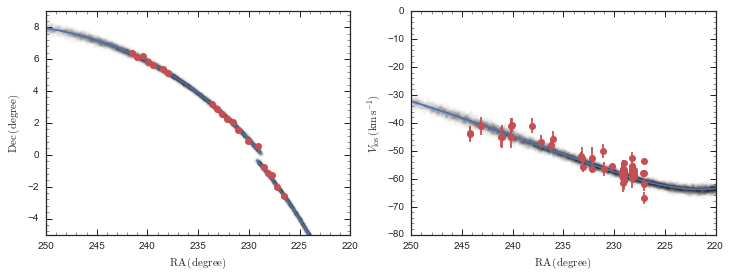

In [9]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

## The orbit of Pal 5 in different flattened and triaxial potentials

In [9]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [10]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

Vary $c$ along the best-fit line:

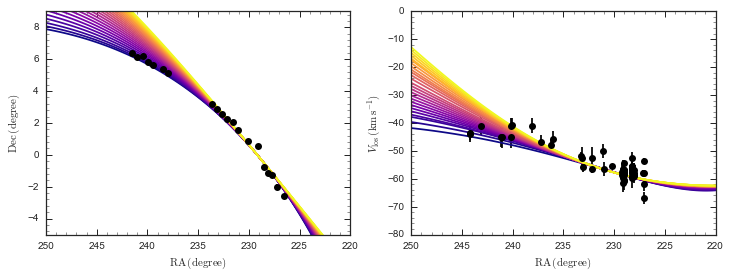

In [12]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')

## How does the track, width, and length of the Pal 5 stream vary with the potential?

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [184]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

In [154]:
reload(pal5_util)
out= pal5_util.pal5_lnlike(pos_radec,rvel_ra,*pal5varyc)

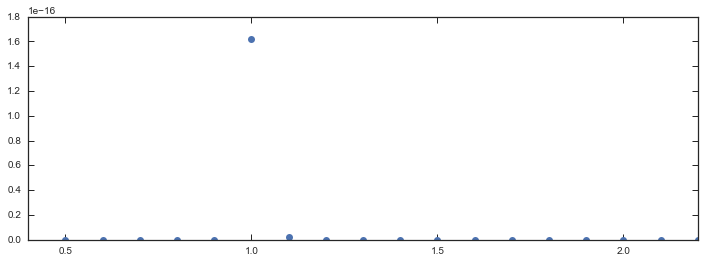

In [155]:
plot(cs,numpy.exp(numpy.sum(out[:,:3],axis=1)),'o')

In [156]:
numpy.arange(0.5,2.6,0.1)

array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5])

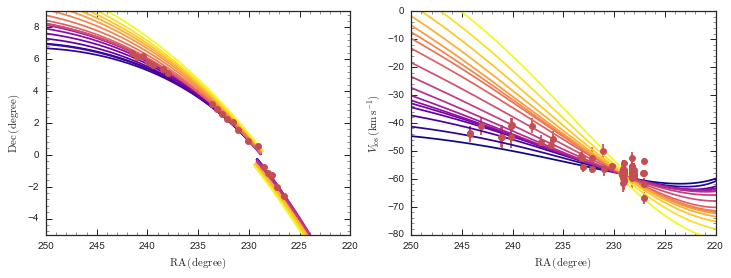

In [157]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()

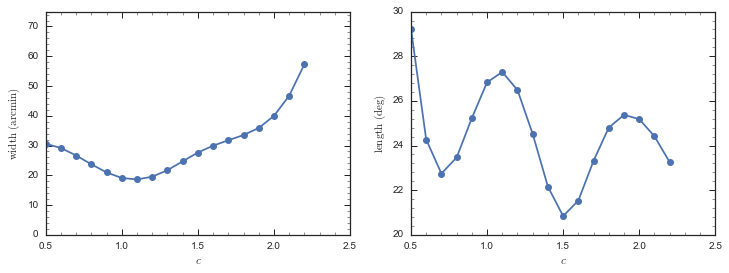

In [158]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Let's now try to make all streams 18' wide and 25 degree long:

In [185]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-constwl.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_constwl= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    interpcs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    ipw= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[4],k=3)
    ipl= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[5],k=3)
    sigv=0.4*18./ipw(interpcs)
    td=5.*25./ipl(interpcs)/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_constwl= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                                 interpcs=interpcs,
                                                 sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_constwl)

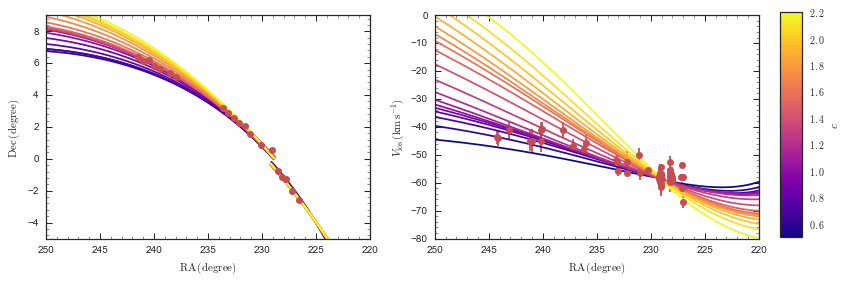

In [186]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Directly compare a subset ($c=0.5$ to $2.1$ in $0.2$ increments):

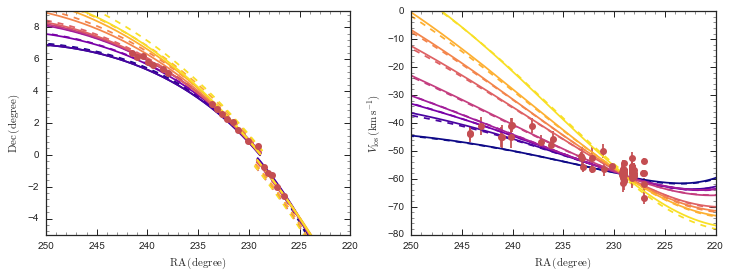

In [187]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs[::2]):
    ii*= 2
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
plot_data_add_labels()

The differences are small, especially around $c\approx1$. The width and length of the stream, pre-correction in green:

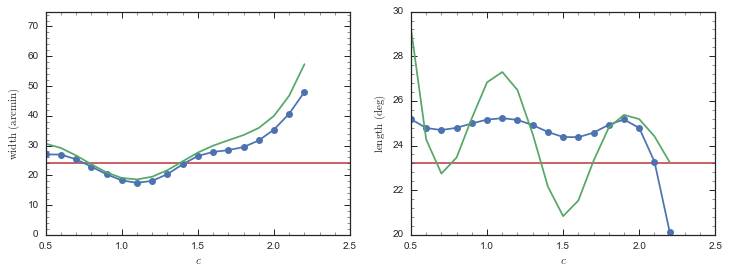

In [188]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

It appears that the increase in the stream age undoes the effect of making the stream colder on the width of the stream. This raises the question whether it is at all possible to have a long, cold stream in these $c\neq1$ potentials.

A test with double the number of track points, to see whether that matters. It does not:

In [162]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-ntc16.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=16,nTrackChunks=16,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

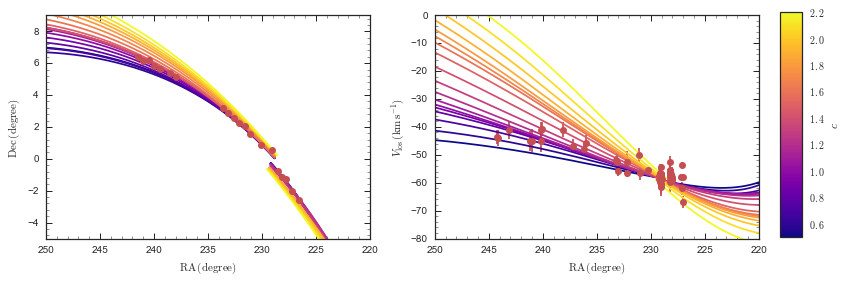

In [163]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Let's take a look at the grid-points themselves, to see whether the same trend shows for them. They do:

In [173]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-singlec.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.55,1.75,2.,2.25])
    trackRADec_trailing_out= numpy.empty((len(cs),1001,2))
    trackRADec_leading_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_trailing_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_leading_out= numpy.empty((len(cs),1001,2))
    width_out= numpy.empty(len(cs))
    length_out= numpy.empty(len(cs))
    for ii,c in enumerate(cs):
        tpal5varyc= pal5_util.predict_pal5obs(p_b15,c,multi=8,singlec=True)
        trackRADec_trailing_out[ii]= tpal5varyc[0]
        trackRADec_leading_out[ii]= tpal5varyc[1]
        trackRAVlos_trailing_out[ii]= tpal5varyc[2]
        trackRAVlos_leading_out[ii]= tpal5varyc[3]
        width_out[ii]= tpal5varyc[4]
        length_out[ii]= tpal5varyc[5]
    pal5varyc= (trackRADec_trailing_out,trackRADec_leading_out,
                trackRAVlos_trailing_out,trackRAVlos_leading_out,
                width_out,length_out)
    save_pickles(savefilename,cs,pal5varyc)

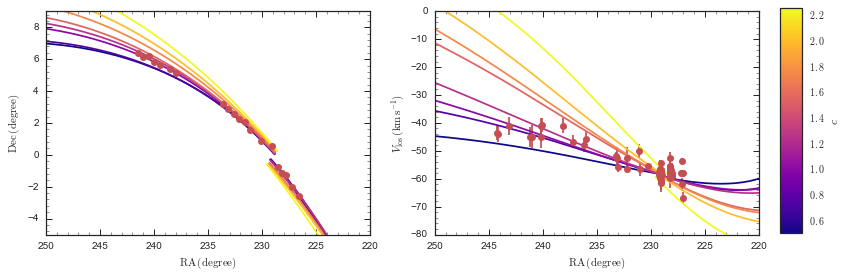

In [174]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

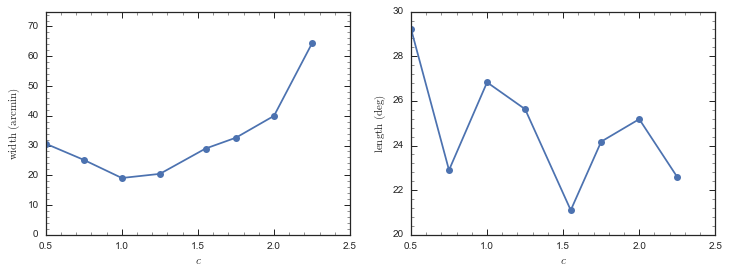

In [175]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

What happens when we use a denser interpolation grid?

In [189]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-densergrid.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.05)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.,2.1,2.2])
    save_pickles(savefilename,cs,pal5varyc)

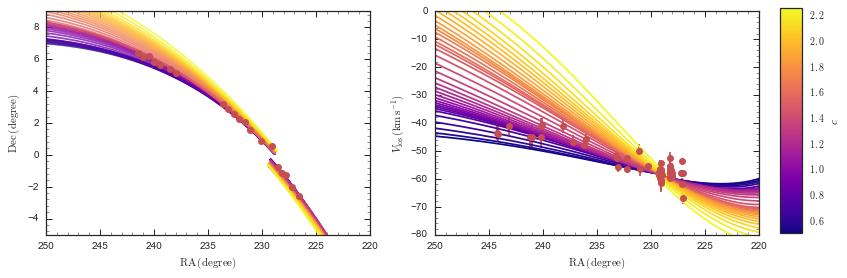

In [190]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

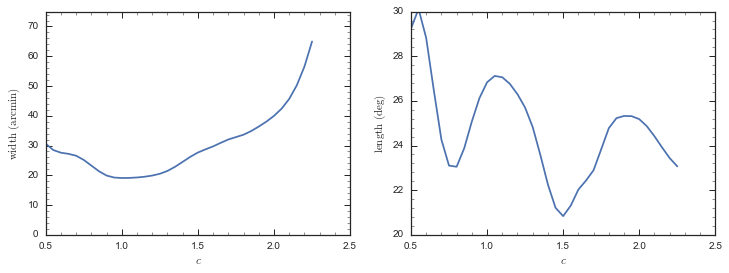

In [191]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Does this change for different potential parameters?

In [112]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-shortscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

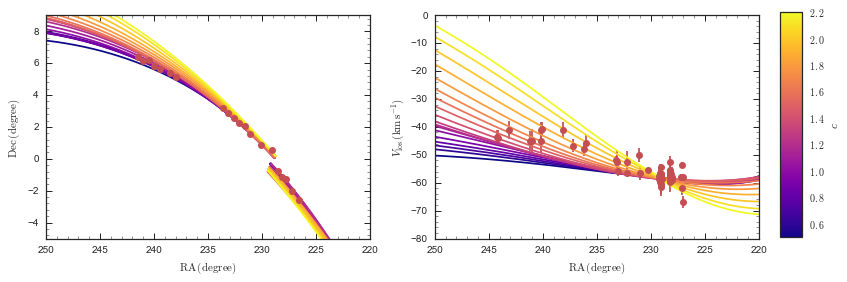

In [113]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < .95 or (c > 1.05 and c < 1.25): continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

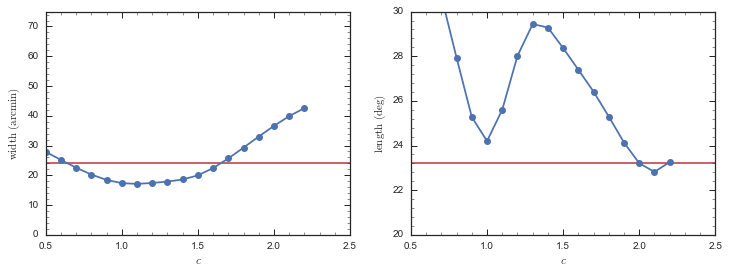

In [108]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another different potential:

In [219]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-longscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

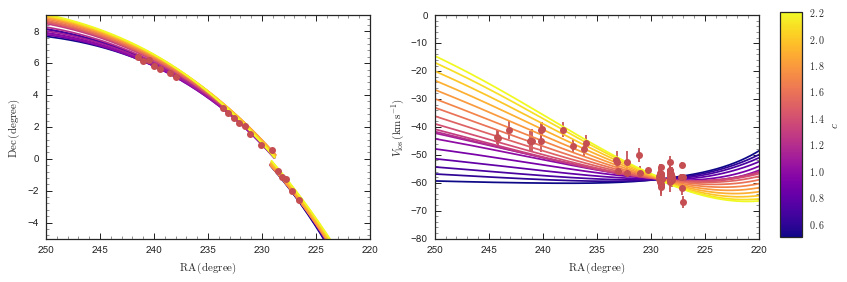

In [220]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

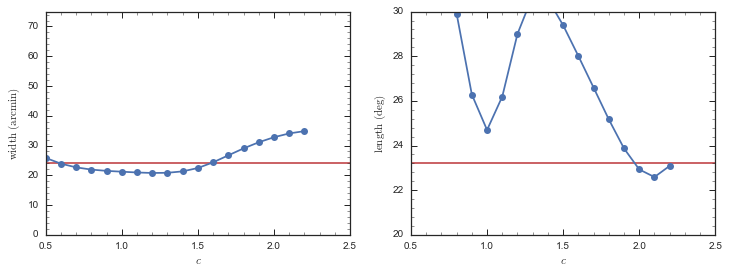

In [125]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another one to test:

In [150]:
p_b15= [0.45,0.45,-1.,-3.2,0.9,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-somescale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

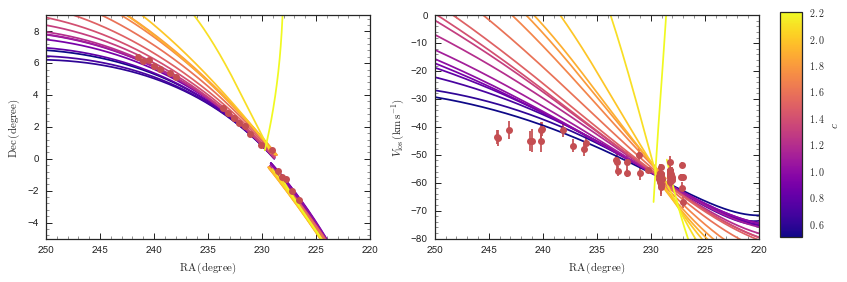

In [151]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

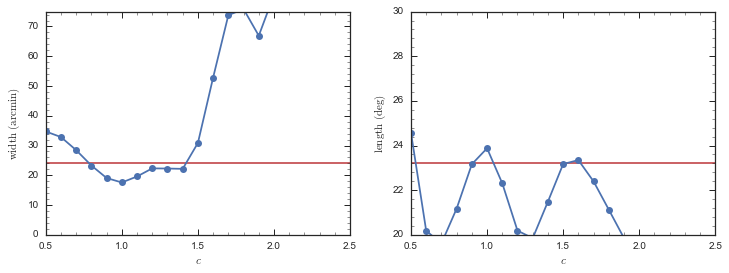

In [152]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## Some likelihoods for fixed sets of parameters

In [221]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-like.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_like= pickle.load(savefile)
else:
    # First just compute the interpolation points, to adjust the width and length
    interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25]
    pal5varyc= pal5_util.predict_pal5obs(p_b15,interpcs,multi=8,interpcs=interpcs)
    cs= numpy.arange(0.5,2.21,0.01)
    sigv=0.4*18./pal5varyc[4]
    td=5.*25./pal5varyc[5]/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_like= pal5_util.predict_pal5obs(p_b15,cs,multi=8,interpcs=pal5varyc[6],
                                              sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_like)

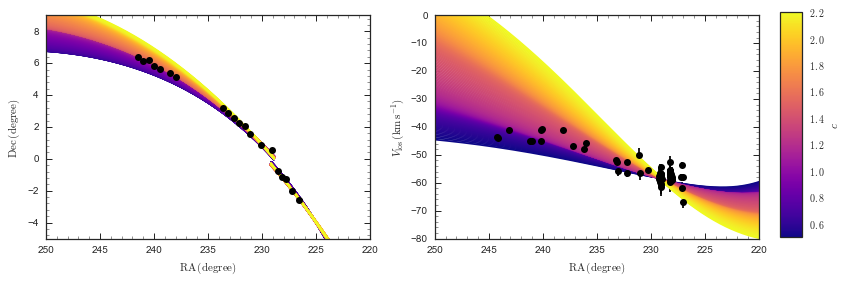

In [225]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_like[0][ii,:,0],
                        pal5varyc_like[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[1][ii,:,0],
                        pal5varyc_like[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_like[2][ii,:,0],
                        pal5varyc_like[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[3][ii,:,0],
                        pal5varyc_like[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels('k')
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

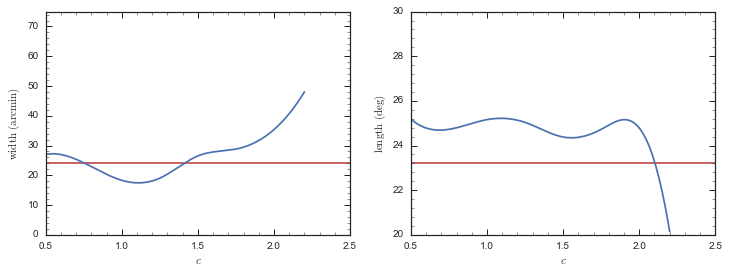

In [195]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_like[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_like[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

In [200]:
reload(pal5_util)
out= pal5_util.pal5_lnlike(pos_radec,rvel_ra,*pal5varyc_like)

Mode, mean, std.dev., P(c<1): 1.04 1.05034136858 0.0301829291315 0.0416808139734


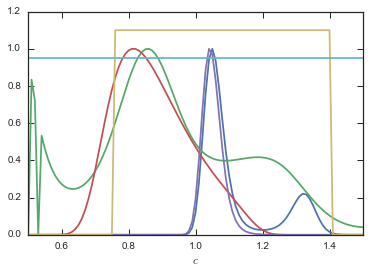

In [218]:
figsize(6,4)
plot(cs,numpy.exp(out[:,0]-numpy.amax(out[:,0])))
plot(cs,numpy.exp(out[:,1]-numpy.amax(out[:,1])))
plot(cs,numpy.exp(out[:,2]-numpy.amax(out[:,2])))
comb= numpy.exp(numpy.sum(out[:,:3],axis=1)-numpy.amax(numpy.sum(out[:,:3],axis=1)))
comb[out[:,3] > 24.]= 0.
comb[out[:,4] < 23.2]= 0.
plot(cs,comb)
m= numpy.sum(cs*comb)/numpy.sum(comb)
plot(cs,(out[:,3] < 24.)*1.1)
plot(cs,(out[:,4] > 23.2)*0.95)
xlabel(r'$c$')
xlim(0.5,1.5)
ylim(0.,1.2)
print "Mode, mean, std.dev., P(c<1):" ,\
    cs[numpy.argmax(comb)], m, numpy.sqrt(numpy.sum((cs-m)**2.*comb)/numpy.sum(comb)), \
    numpy.cumsum(comb/numpy.sum(comb))[numpy.fabs(cs-1.) < 0.005][0]

In [5]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25])
pot= MWPotential2014Likelihood.setup_potential(p_b15,0.5,False,False,ro,vo)
tsdf_trailing, tsdf_leading= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,isob=0.5)

In [42]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25])
pot= MWPotential2014Likelihood.setup_potential(p_b15,0.8,False,False,ro,vo)
tsdf_trailing, tsdf_leading= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,isob=2.)

In [60]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25])
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.4,False,False,ro,vo)
tsdf_trailing, tsdf_leading= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,isob=0.67)

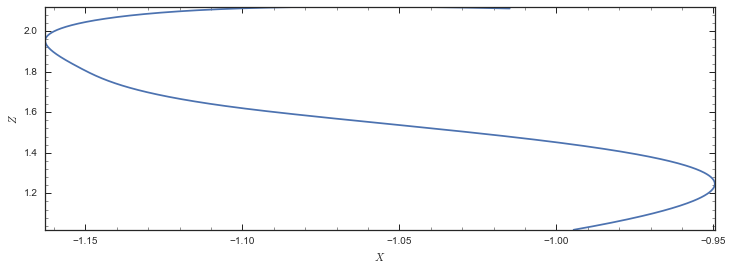

In [61]:
tsdf_trailing.plotTrack()

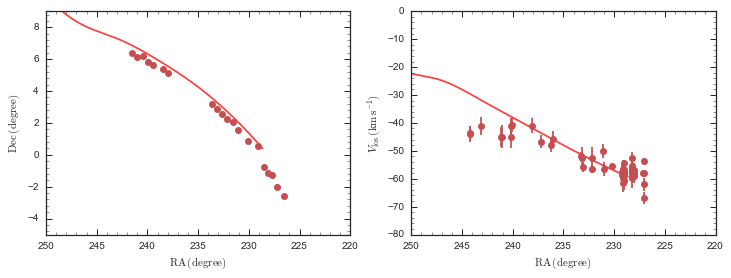

In [62]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_trailing._interpolatedObsTrackLB[:,0],
                        tsdf_trailing._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_trailing._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

In [53]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25])
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
tsdf_trailing_fid, tsdf_leading_fid= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo)

In [50]:
tsdf_trailing.meanOmega(0.1,oned=False,use_physical=True), \
    tsdf_trailing._progenitor_Omega*bovy_conversion.freq_in_Gyr(vo,ro)

(array([ 8.96783288,  8.15125934,  8.90279294]),
 array([ 14.2820741 ,  12.54792537,  13.58206595]))

In [73]:
for sdf in [tsdf_trailing,tsdf_trailing_fid]:
    print sdf._progenitor.jphi(type='isochroneapprox',b=0.8)

AttributeError: 'Orbit' object has no attribute 'jphi'

In [56]:
from galpy.actionAngle import estimateBIsochrone
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
#p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
#p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25])
ts= numpy.linspace(0.,150.,1001)
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.4,False,False,ro,vo)
prog.integrate(ts,pot)
estimateBIsochrone(pot,prog.R(ts,use_physical=False),prog.z(ts,use_physical=False))

array([ 0.31540008,  0.67446447,  0.87606007])

In [101]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [27]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
#bf_params= bf_params[::5]
#cs= cs[::5]

In [28]:
cs

array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
        2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
        3.8,  3.9,  4. ])

In [234]:
sdf_trailing_varyc= []
sdf_leading_varyc= []
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
    sigv= 0.4
    try:
        tsdf_trailing= streamdf(sigv/vo,progenitor=prog,
                                pot=pot,aA=aAI,
                                leading=False,nTrackChunks=11,
                                tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                                ro=ro,vo=vo,R0=ro,
                                vsun=[-11.1,vo+24.,7.25],
                                custom_transform=pal5_util._TPAL5)
    except numpy.linalg.LinAlgError:
        tsdf_trailing= streamdf(sigv/vo,progenitor=prog,
                                pot=pot,aA=aAI,
                                leading=False,nTrackChunks=11,nTrackIterations=0,
                                tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                                ro=ro,vo=vo,R0=ro,
                                vsun=[-11.1,vo+24.,7.25],
                                custom_transform=pal5_util._TPAL5)
    try:
        tsdf_leading= streamdf(sigv/vo,progenitor=prog,
                               pot=pot,aA=aAI,
                               leading=True,nTrackChunks=11,
                               tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                               ro=ro,vo=vo,R0=ro,
                               vsun=[-11.1,vo+24.,7.25],
                               custom_transform=pal5_util._TPAL5)
    except numpy.linalg.LinAlgError:
        tsdf_leading= streamdf(sigv/vo,progenitor=prog,
                               pot=pot,aA=aAI,
                               leading=True,nTrackChunks=11,nTrackIterations=0,
                               tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                               ro=ro,vo=vo,R0=ro,
                               vsun=[-11.1,vo+24.,7.25],
                               custom_transform=pal5_util._TPAL5)
    sdf_trailing_varyc.append(tsdf_trailing)
    sdf_leading_varyc.append(tsdf_leading)

In [209]:
cs= cs[:5]

In [86]:
#cs= cs[:24]

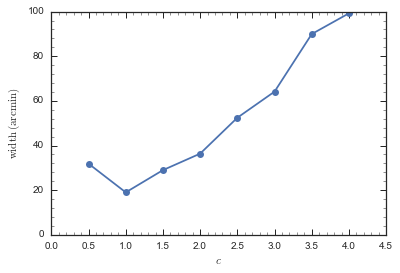

In [237]:
figsize(6,4)
widths_varyc= numpy.zeros(len(cs))
for ii in range(len(cs)):
    widths_varyc[ii]= width_trailing(sdf_trailing_varyc[ii])
bovy_plot.bovy_plot(cs,widths_varyc,'o-',
                    xlabel=r'$c$',ylabel=r'$\mathrm{width}\,(\mathrm{arcmin})$',
                    xrange=[0.,4.5],yrange=[0.,100.])

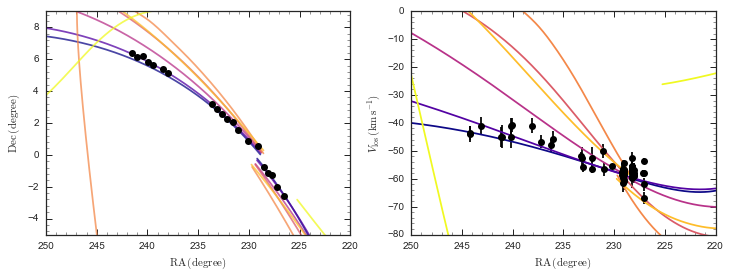

In [262]:
figsize(12,4)
cmap= cm.plasma
maxi= 1001
for ii,c in enumerate(cs):
    if numpy.fabs(c-1.5) < 0.01: continue
    tc= cmap((c-0.5)/3.5)
    ttrackRADec_trailing=\
      bovy_coords.lb_to_radec(sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    ttrackRADec_leading=\
      bovy_coords.lb_to_radec(sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    subplot(1,2,1)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        ttrackRADec_trailing[:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        ttrackRADec_leading[:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
plot_data_add_labels('k')

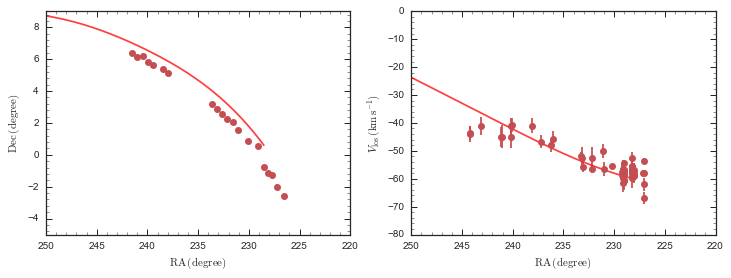

In [38]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

(-15.0, 40)

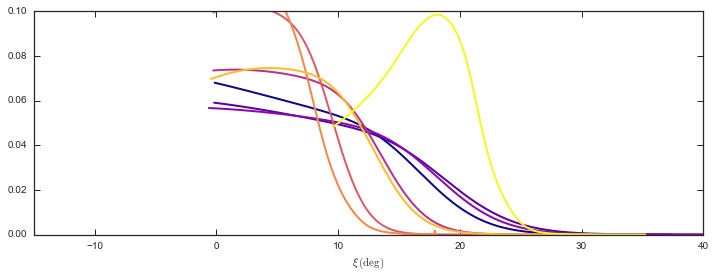

In [268]:
for ii,(sdf,c) in enumerate(zip(sdf_trailing_varyc,cs)):
    tc= cmap((c-0.5)/3.5)
    ttrackRADec_trailing=\
      bovy_coords.lb_to_radec(sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    trackxieta_trailing= pal5_util.radec_to_pal5xieta(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],degree=True)
    dens_xi= numpy.array([sdf.density_par(x,coord='customra') for x in sdf._interpolatedThetasTrack])
    plot(trackxieta_trailing[:,0],dens_xi/numpy.sum(dens_xi*(
     numpy.roll(trackxieta_trailing[:,0],-1)-trackxieta_trailing[:,0])),lw=2.,color=tc)
xlabel(r'$\xi\,(\mathrm{deg})$')
ylim(0.,0.1)
xlim(-15.,40)

In [271]:
for ii,(sdf,c) in enumerate(zip(sdf_trailing_varyc,cs)):
    print c,sdf.length(ang=True), width_trailing(sdf)

0.5 27.821230741 31.8640049368
1.0 30.8065644027 19.0128399914
1.5 30.6000045536 28.9804327395
2.0 24.2845086292 36.3708684022
2.5 19.65185725 52.4556140625
3.0 19.0451535185 64.1504808223
3.5 25.24331602 89.9470947894
4.0 15.9212296397 99.2361384821


In [274]:
for ii,(sdf,c) in enumerate(zip(sdf_trailing_varyc,cs)):
    print c, sdf._detdOdJps/sdf_trailing_varyc[1]._detdOdJps


0.5 [ 2.77431273  2.7211448   2.70178778  2.70143701  2.73097119  2.77457671
  2.53589732  2.64464712  2.47515264  2.37311185  2.29866134]
1.0 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.5 [-0.13543201 -0.13058799 -0.126991   -0.12447036 -0.1259808  -0.13751535
 -0.14553226 -0.17891263 -0.18933767 -0.2134021  -0.22063563]
2.0 [-0.6919841  -0.67977277 -0.6770426  -0.68039945 -0.69459954 -0.7177839
 -0.66875516 -0.71086791 -0.67606685 -0.65587046 -0.63757206]
2.5 [-0.98828086 -1.01600152 -1.03475082 -1.04853472 -1.05987463 -1.05936796
 -0.96168652 -1.04467968 -1.06893851 -1.1429191  -1.06309265]
3.0 [-1.35485643 -1.19837539 -1.12721877 -1.23648555 -1.33964178 -1.37279505
 -1.40094646 -1.58635677 -1.40408415 -2.11424344  1.4540323 ]
3.5 [-3.13597549 -3.21914058 -3.20341878 -3.33915498 -3.67537264 -4.00293663
 -3.84939913 -4.19021162 -4.00132233 -4.08978779 -3.68409226]
4.0 [ 105.50536768  107.47549234  142.88499769  454.64562403 -279.00048545
 -177.06613545 -381.39782754  -74.0436876 

In [93]:
sdf_trailing_varyc_corrw= []
sdf_leading_varyc_corrw= []
for bp,c,w in zip(bf_params,cs,widths_varyc):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
    sigv= 0.4*(18./w)
    td= 5./bovy_conversion.time_in_Gyr(vo,ro)/*(18./w)
    tsdf_trailing= streamdf(sigv/vo,progenitor=prog,
                            pot=pot,aA=aAI,
                            leading=False,nTrackChunks=11,
                            tdisrupt=td,
                            ro=ro,vo=vo,R0=ro,
                            vsun=[-11.1,vo+24.,7.25],
                            custom_transform=pal5_util._TPAL5)
    tsdf_leading= streamdf(sigv/vo,progenitor=prog,
                           pot=pot,aA=aAI,
                           leading=True,nTrackChunks=11,
                           tdisrupt=td,
                           ro=ro,vo=vo,R0=ro,
                           vsun=[-11.1,vo+24.,7.25],
                           custom_transform=pal5_util._TPAL5)
    sdf_trailing_varyc_corrw.append(tsdf_trailing)
    sdf_leading_varyc_corrw.append(tsdf_leading)

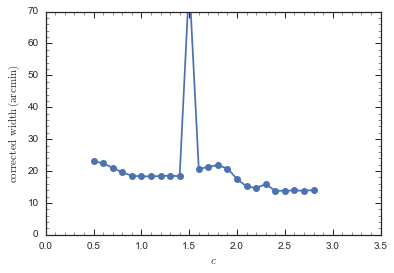

In [95]:
figsize(6,4)
widths_varyc_corrw= numpy.zeros(len(cs))
for ii in range(len(cs)):
    widths_varyc_corrw[ii]= width_trailing(sdf_trailing_varyc_corrw[ii])
bovy_plot.bovy_plot(cs,widths_varyc_corrw,'o-',
                    xlabel=r'$c$',ylabel=r'$\mathrm{corrected\ width}\,(\mathrm{arcmin})$',
                    xrange=[0.,3.5],yrange=[0.,70.])

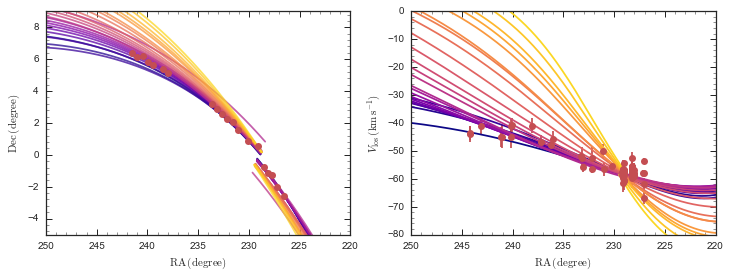

In [98]:
figsize(12,4)
cmap= cm.plasma
maxi= 1001
for ii,c in enumerate(cs):
    tc= cmap((c-0.5)/2.5)
    ttrackRADec_trailing=\
      bovy_coords.lb_to_radec(sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    ttrackRADec_leading=\
      bovy_coords.lb_to_radec(sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    subplot(1,2,1)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        ttrackRADec_trailing[:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        ttrackRADec_leading[:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        sdf_trailing_varyc[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        sdf_leading_varyc[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
plot_data_add_labels()

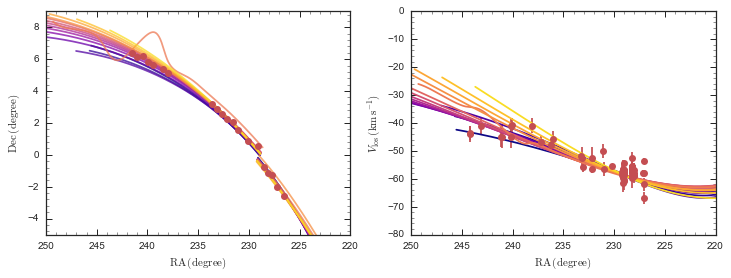

In [100]:
figsize(12,4)
cmap= cm.plasma
maxi= 1001
for ii,c in enumerate(cs[:15]):
    tc= cmap((c-0.5)/1.5)
    ttrackRADec_trailing=\
      bovy_coords.lb_to_radec(sdf_trailing_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_trailing_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    ttrackRADec_leading=\
      bovy_coords.lb_to_radec(sdf_leading_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,0],
                              sdf_leading_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,1],
                              degree=True)
    subplot(1,2,1)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        ttrackRADec_trailing[:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        ttrackRADec_leading[:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                        sdf_trailing_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(ttrackRADec_leading[:,0],
                        sdf_leading_varyc_corrw[ii]._interpolatedObsTrackLB[:maxi,3],
                        color=tc,overplot=True)
plot_data_add_labels()

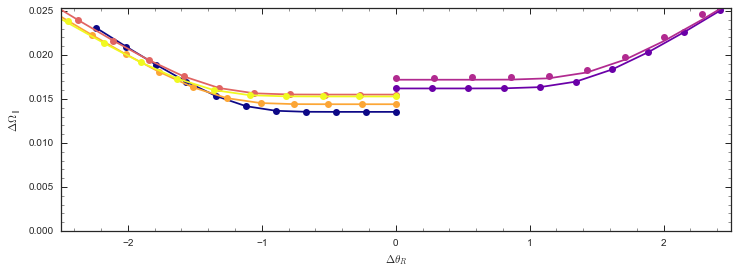

In [69]:
sdf_trailing_varyc[0].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][0]-0.5)/2.5),xrange=[-2.5,2.5])
sdf_trailing_varyc[1].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][1]-0.5)/2.5),overplot=True)
sdf_trailing_varyc[2].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][2]-0.5)/2.5),overplot=True)
sdf_trailing_varyc[3].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][3]-0.5)/2.5),overplot=True)
sdf_trailing_varyc[4].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][4]-0.5)/2.5),overplot=True)
sdf_trailing_varyc[5].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][5]-0.5)/2.5),overplot=True)

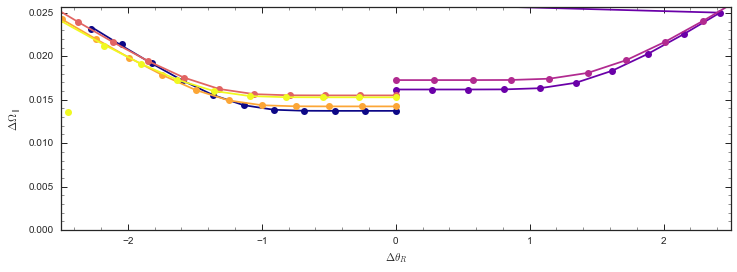

In [70]:
sdf_leading_varyc[0].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][0]-0.5)/2.5),xrange=[-2.5,2.5])
sdf_leading_varyc[1].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][1]-0.5)/2.5),overplot=True)
sdf_leading_varyc[2].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][2]-0.5)/2.5),overplot=True)
sdf_leading_varyc[3].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][3]-0.5)/2.5),overplot=True)
sdf_leading_varyc[4].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][4]-0.5)/2.5),overplot=True)
sdf_leading_varyc[5].plotCompareTrackAAModel(color=cmap((cs[::5][:-2][5]-0.5)/2.5),overplot=True)

In [90]:
len(cs), cs, cs[10]

(36, array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
         1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
         2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
         3.8,  3.9,  4. ]), 1.4999999999999998)

In [7]:
ro,vo= _REFR0,_REFV0

In [197]:
pot= MWPotential2014Likelihood.setup_potential(bf_params[10],cs[10]-0.06,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)

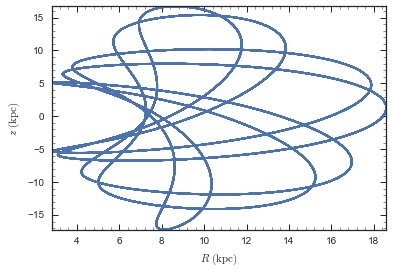

In [198]:
times= numpy.linspace(0.,1000.,10001)
progf= prog.flip()
progf.integrate(times,pot)
progf.plot()

In [33]:
cs[8]

1.2999999999999998

In [38]:
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(bf_params[7],cs[7]+0.05,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8,tintJ=100.,ntintJ=10000)
sigv= 0.4
tsdf_leading= streamdf(sigv/vo,progenitor=prog,
                        pot=pot,aA=aAI,deltaAngleTrack=3.,
                        leading=False,nTrackChunks=11,nTrackIterations=None,
                        tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                        ro=ro,vo=vo,R0=ro,
                        vsun=[-11.1,vo+24.,7.25],
                        custom_transform=pal5_util._TPAL5,
                      nosetup=False)

In [ ]:
tsdf_leading._interpolatedThetasTrack

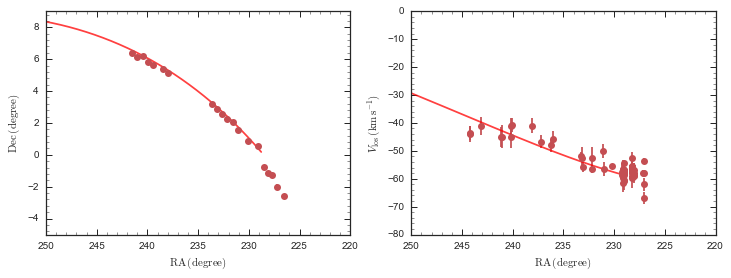

In [39]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

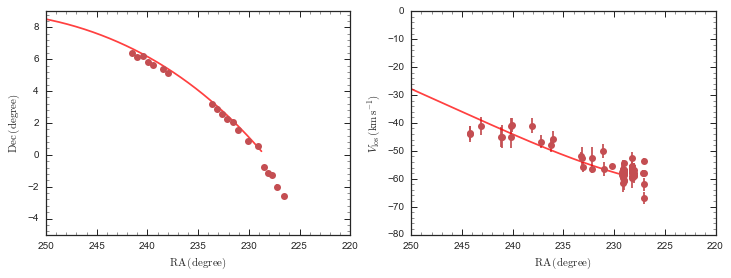

In [30]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

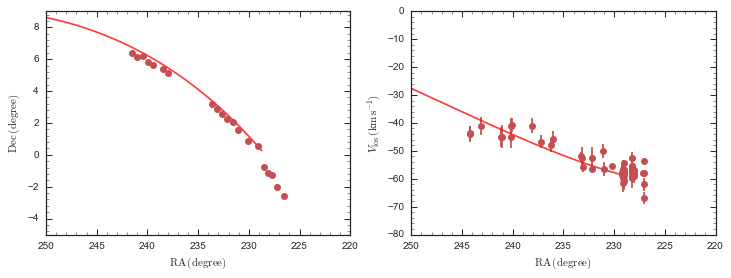

In [53]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

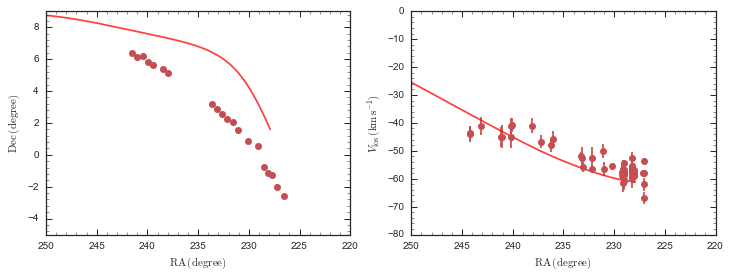

In [57]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

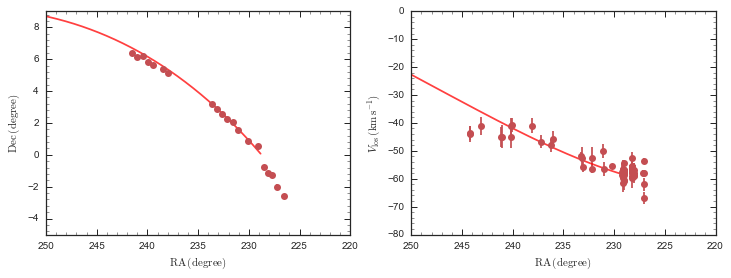

In [32]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

In [26]:
sdf_trailing.nInterpolatedTrackChunks

1001

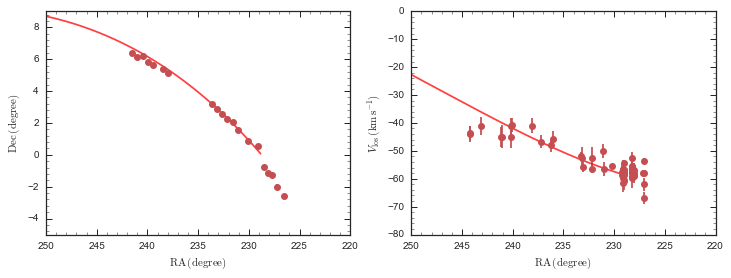

In [59]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

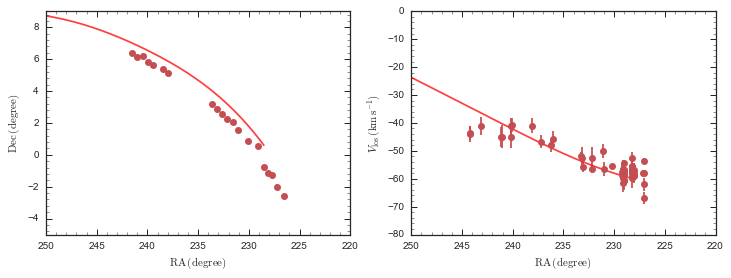

In [34]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

In [27]:
tsdf_leading._alljacsTrack[1]/.01, numpy.linalg.eig(tsdf_leading._alljacsTrack[1])[0]

(array([[  9.99849570e+04,   3.01010239e+01,  -5.31124633e+01,
          -2.88815773e+01,  -3.26759175e+00,  -2.22044606e-05],
        [ -1.04928722e+01,   1.00018254e+05,  -3.06801607e+01,
          -1.99741103e+01,  -1.25559563e-01,  -1.77635685e-05],
        [ -1.10936905e+01,   1.86474680e+01,   9.99684342e+04,
          -2.07361052e+01,   1.21191945e-01,  -1.77635685e-05],
        [  2.57730905e+01,  -1.40243799e+02,   3.64205732e+01,
           9.99862632e+04,  -3.12431467e+02,   1.56319403e-03],
        [ -4.13159287e+00,  -1.56595164e+02,  -5.57137270e+01,
           3.67698763e+00,   9.99167641e+04,   1.00000790e+02],
        [ -8.18161543e+00,   1.45558943e+01,   4.35526460e+01,
           4.71565900e+00,  -1.70737735e+02,   1.00000001e+05]]),
 array([  999.90882303+1.44100139j,   999.90882303-1.44100139j,
          998.76268369+0.j        ,  1000.18196616+0.j        ,
          999.97267534+0.j        ,  1000.01176296+0.j        ]))

In [126]:
(tsdf_leading._alljacsTrack[1]-tsdf_leading_fid._alljacsTrack[1])/tsdf_leading_fid._alljacsTrack[1]

array([[ -4.91882542e-02,   4.54692535e-02,  -1.49768554e-02,
          1.20857406e-02,  -2.32360685e-02,  -5.12500000e+00],
       [ -5.13573754e-02,   4.52490775e-02,  -1.58298448e-02,
          1.38049032e-02,  -2.17649538e-01,  -1.66666667e-01],
       [ -5.21048729e-02,   4.53867850e-02,  -1.11584514e-02,
          1.02862040e-02,   1.02740928e+00,  -5.71428571e-01],
       [  8.29759849e-02,  -1.95555060e-02,  -3.80678551e-03,
         -5.83599618e-03,   5.65410840e-03,  -1.20000000e+01],
       [  1.36458696e-01,   2.51441329e-03,   9.38969860e-02,
          2.44363169e-02,   3.31809227e-02,   3.90799305e-05],
       [  3.07597932e-02,  -1.97556169e-01,  -2.01811215e-02,
         -6.30473942e-03,  -2.99389000e-02,  -7.62500000e+00]])

In [255]:
tsdf_leading._progenitor_Omega, tsdf_leading_fid._progenitor_Omega

(array([ 0.79980646,  0.61293156,  0.54370791]),
 array([ 0.76120334,  0.5499603 ,  0.5428103 ]))

In [231]:
tsdf_leading_fid._dOdJpEig[0]

array([ -1.80574656e+00,   4.76103507e-02,  -1.77313505e-03])

In [228]:
[(cs[ii],sdf_trailing_varyc[ii]._dOdJpEig[0]) for ii in range(len(sdf_leading_varyc))]

[(0.5, array([-1.39647004,  0.04386087, -0.05271076])),
 (0.99999999999999989, array([-1.64552868,  0.04598579, -0.0206966 ])),
 (1.4999999999999998,
  array([ -1.80239139e+00,   4.79290798e-02,  -1.13549901e-03])),
 (1.9999999999999996, array([-1.65493914,  0.06344491,  0.00663943])),
 (2.4999999999999996, array([-1.58235721,  0.0892032 ,  0.00753973]))]

NameError: name 'tsdf_leading_fid' is not defined

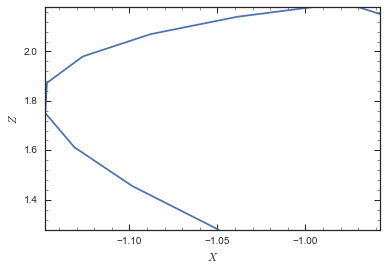

In [28]:
tsdf_leading.plotTrack(interp=False)
tsdf_leading_fid.plotTrack(overplot=True)

In [257]:
tsdf_leading.misalignment()

-4.0319017080456376

In [258]:
numpy.mean(width_trailing(tsdf_leading))

89.238993403703731

In [8]:
tsdf_leading._determine_nTrackIterations(None)

In [9]:
tsdf_leading._determine_stream_track(11)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 1 results
  RuntimeWarning)



In [10]:
tsdf_leading._useInterp= True

In [11]:
tsdf_leading._interpolate_stream_track()

In [12]:
tsdf_leading._interpolate_stream_track_aA()

In [13]:
tsdf_leading.calc_stream_lb()

In [29]:
tsdf_leading._determine_stream_spread()

In [77]:
from galpy.df_src.streamdf import _determine_stream_spread_single
simple= True
allErrCovs= numpy.empty((tsdf_leading._nTrackChunks,6,6))
for ii in range(tsdf_leading._nTrackChunks):
    print ii, tsdf_leading._thetasTrack[ii], tsdf_leading.sigangledAngle(tsdf_leading._thetasTrack[ii],simple=simple,use_physical=False)
    allErrCovs[ii]= _determine_stream_spread_single(tsdf_leading._sigomatrixEig,
                                                    tsdf_leading._thetasTrack[ii],
                                                    lambda x: tsdf_leading.sigOmega(x,use_physical=False),
                                                    lambda y: tsdf_leading.sigangledAngle(y,simple=simple,
                                                                                          use_physical=False),
                                                    tsdf_leading._allinvjacsTrack[ii])
tsdf_leading._allErrCovs= allErrCovs
allErrCovsXY= numpy.empty_like(tsdf_leading._allErrCovs)
allErrCovsEigvalXY= numpy.empty((len(tsdf_leading._thetasTrack),6))
allErrCovsEigvecXY= numpy.empty_like(tsdf_leading._allErrCovs)
eigDir= numpy.array([numpy.array([1.,0.,0.,0.,0.,0.]) for ii in range(6)])

0 0.0 0.0267494618905
1 0.39843491179 0.00560863901162
2 0.79686982358 0.0096796226603
3 1.19530473537 0.014050819679
4 1.59373964716 0.0182788983832
5 1.99217455895 0.0216963708375
6 2.39060947074 0.0238481158202
7 2.78904438253 0.0250327336199
8 3.18747929432 0.0257711145221
9 3.58591420611 0.0267494618905
10 3.9843491179 0.0267494618905


In [112]:
from galpy.df_src.streamdf import _determine_stream_track_single
dt= tsdf_leading._deltaAngleTrack\
            /tsdf_leading._progenitor_Omega_along_dOmega
prog_stream_offset=\
            _determine_stream_track_single(tsdf_leading._aA,
                                           tsdf_leading._progenitor,
                                           0., #time = 0
                                           tsdf_leading._progenitor_angle,
                                           tsdf_leading._sigMeanSign,
                                           tsdf_leading._dsigomeanProgDirection,
                                           lambda x: tsdf_leading.meanOmega(x,use_physical=False),
                                           0.) #angle = 0
auxiliaryTrack= Orbit(prog_stream_offset[3])
if dt < 0.:
    self._trackts= numpy.linspace(0.,-2.*dt,2.*tsdf_leading._nTrackChunks-1)
    auxiliaryTrack= auxiliaryTrack.flip()
auxiliaryTrack.integrate(tsdf_leading._trackts,tsdf_leading._pot)
if dt < 0.:
    #Flip velocities again
    auxiliaryTrack._orb.orbit[:,1]= -auxiliaryTrack._orb.orbit[:,1]
    auxiliaryTrack._orb.orbit[:,2]= -auxiliaryTrack._orb.orbit[:,2]
    auxiliaryTrack._orb.orbit[:,4]= -auxiliaryTrack._orb.orbit[:,4]
#Calculate the actions, frequencies, and angle for this auxiliary orbit
acfs= tsdf_leading._aA.actionsFreqs(auxiliaryTrack(0.),maxn=3,
                                    use_physical=False)
auxiliary_Omega= numpy.array([acfs[3],acfs[4],acfs[5]]).reshape(3)
auxiliary_Omega_along_dOmega= \
   numpy.dot(auxiliary_Omega,tsdf_leading._dsigomeanProgDirection)
allAcfsTrack= numpy.empty((tsdf_leading._nTrackChunks,9))
alljacsTrack= numpy.empty((tsdf_leading._nTrackChunks,6,6))
allinvjacsTrack= numpy.empty((tsdf_leading._nTrackChunks,6,6))
thetasTrack= numpy.linspace(0.,tsdf_leading._deltaAngleTrack,
                                    tsdf_leading._nTrackChunks)
ObsTrack= numpy.empty((tsdf_leading._nTrackChunks,6))
ObsTrackAA= numpy.empty((tsdf_leading._nTrackChunks,6))
detdOdJps= numpy.empty((tsdf_leading._nTrackChunks))
ii= 0
multiOut= _determine_stream_track_single(tsdf_leading._aA,auxiliaryTrack,tsdf_leading._trackts[ii]\
                    *numpy.fabs(tsdf_leading._progenitor_Omega_along_dOmega/auxiliary_Omega_along_dOmega), 
                                tsdf_leading._progenitor_angle,
                                                         tsdf_leading._sigMeanSign,
                                                         tsdf_leading._dsigomeanProgDirection,
                                                         lambda x: tsdf_leading.meanOmega(x,use_physical=False),
                                                         thetasTrack[ii])

NameError: name 'self' is not defined

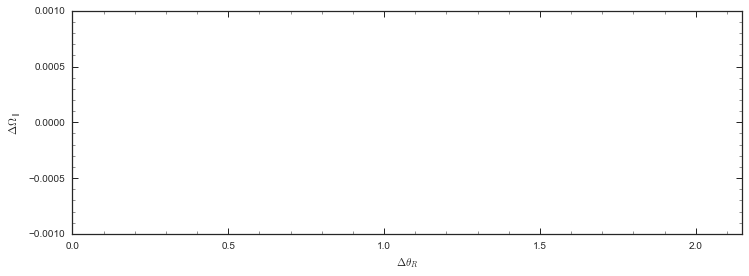

In [41]:
tsdf_leading.plotCompareTrackAAModel()

In [25]:
tsdf_leading.misalignment()

1.4335277638254058

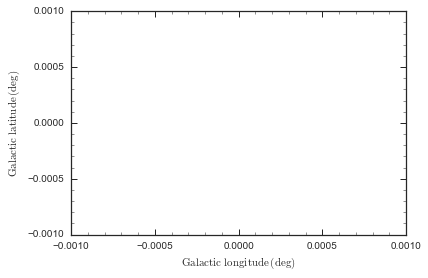

In [70]:
tsdf_leading.plotTrack(d1='ll',d2='bb',marker='o',ls='none')

In [102]:
tsdf_leading._sigjz

0.0024837163037405353

In [73]:
tsdf_leading._allAcfsTrack

array([[  0.16159014,   0.59286426,   0.12137005,   0.50021673,
          0.3882542 ,   0.33754624,   4.93063853,   0.15726525,
          0.29230405],
       [  0.29137399,   0.58343907,   0.33401566,   0.81451123,
          0.62657452,   0.54854928,   3.62681432,   3.65011802,
          1.89218379],
       [  0.30624831,   0.56607413,   0.32649519,   0.81940746,
          0.62900375,   0.54771022,   3.80494618,   3.79169542,
          2.05894962],
       [         nan, -30.36967105,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan],
       [         nan, -10.11850108,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan],
       [         nan,  20.02020046,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan],
       [  0.27425077,   0.65138683,   0.29845668,   0.81382151,
          0.62290239,   0.5467

In [32]:
bovy_coords.lb_to_radec(*tsdf_leading._ObsTrackLB[9][:2],degree=True)

(204.35997364870266, -57.858507699461185)

In [91]:
tsdf_leading.misalignment()

-4.7293549076892418

In [89]:
tsdf_leading._deltaAngleTrack

3.9843491178981982

In [78]:
def problem(ii):
    tjac= bovy_coords.cyl_to_rect_jac(*tsdf_leading._ObsTrack[ii])
    allErrCovsXY[ii]=\
         numpy.dot(tjac,numpy.dot(tsdf_leading._allErrCovs[ii],tjac.T))
    print tsdf_leading._allErrCovs[ii]
#    print allErrCovsXY[ii]
#    print numpy.linalg.det(allErrCovsXY[ii])
    teig= numpy.linalg.eig(allErrCovsXY[ii])

In [73]:
problem(9)

[[  1.15599564e-04   6.45828956e-03  -7.22766954e-05   1.19425739e-02
    3.33552728e-03  -6.57293305e-03]
 [  6.45828956e-03   3.92029653e-01  -4.63594447e-03   7.19910987e-01
    2.00472377e-01  -3.95340095e-01]
 [ -7.22766954e-05  -4.63594447e-03   6.07172553e-05  -8.51385368e-03
   -2.36484194e-03   4.65495196e-03]
 [  1.19425739e-02   7.19910987e-01  -8.51385368e-03   1.32356083e+00
    3.68644461e-01  -7.27146239e-01]
 [  3.33552728e-03   2.00472377e-01  -2.36484194e-03   3.68644461e-01
    1.02687948e-01  -2.02550840e-01]
 [ -6.57293305e-03  -3.95340095e-01   4.65495196e-03  -7.27146239e-01
   -2.02550840e-01   4.00483913e-01]]


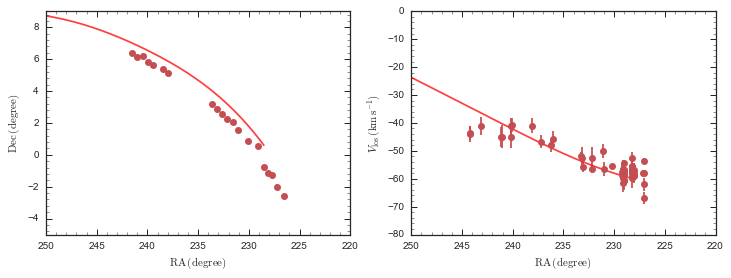

In [34]:
figsize(12,4)
tc= 'r'
ttrackRADec_trailing=\
bovy_coords.lb_to_radec(tsdf_leading._interpolatedObsTrackLB[:,0],
                        tsdf_leading._interpolatedObsTrackLB[:,1],
                        degree=True)
subplot(1,2,1)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    ttrackRADec_trailing[:,1],
                    color=tc,overplot=True,alpha=0.75)
subplot(1,2,2)
bovy_plot.bovy_plot(ttrackRADec_trailing[:,0],
                    tsdf_leading._interpolatedObsTrackLB[:,3],
                    color=tc,overplot=True,alpha=0.75)
plot_data_add_labels()

Setup the progenitor orbit and figure out a good actionAngleIsochroneApprox. We'll take the values from Fritz & Kallivayalil, and compare them to their stream positions and to the Kuzma et al. radial velocities. Provided we put Pal 5 at the maximum possible distance, this fits well:

In [2]:
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=R0,vo=V0,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.8)
sigv= 0.6

In [3]:
sdf_trailing= streamdf(sigv/220.,progenitor=prog,
                       pot=MWPotential2014,aA=aAI,
                       leading=False,nTrackChunks=11,
                       tdisrupt=5./bovy_conversion.time_in_Gyr(V0,R0),
                       Rnorm=R0,Vnorm=V0,R0=R0,
                       vsun=[-11.1,V0+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/220.,progenitor=prog,
                      pot=MWPotential2014,aA=aAI,
                      leading=True,nTrackChunks=11,
                      tdisrupt=5./bovy_conversion.time_in_Gyr(V0,R0),
                      Rnorm=R0,Vnorm=V0,R0=R0,
                      vsun=[-11.1,V0+24.,7.25],
                      custom_transform=pal5_util._TPAL5)
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)

In [18]:
cindx= numpy.argmin(numpy.fabs(trackRADec_trailing[:,0]-235.))
xy= [sdf_trailing._interpolatedObsTrackLB[cindx,0],None,None,None,None,None]
print xy
2.355*60.*numpy.sqrt(sdf_trailing.gaussApprox(xy=xy,lb=True,
                                             cindx=range(len(trackRADec_trailing))[cindx])[1][0,0])

[10.548744569536701, None, None, None, None, None]
(array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5]]), array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]]))


18.383279709897248

(210.0, 250.0)

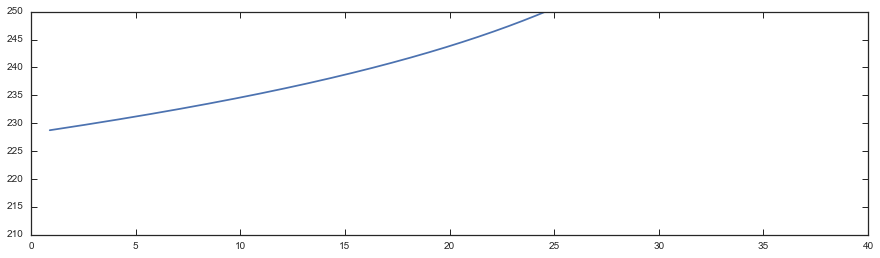

In [121]:
plot(sdf_trailing._interpolatedObsTrackLB[:,0],trackRADec_trailing[:,0])
ylim(210.,250.)

In [15]:
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

In [16]:
print "Physical length: %f kpc (leading,trailing)=(%f,%f) kpc" % \
    (sdf_leading.length(phys=True)+sdf_trailing.length(phys=True),
     sdf_leading.length(phys=True),sdf_trailing.length(phys=True))
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True)+sdf_trailing.length(ang=True),
     sdf_leading.length(ang=True),sdf_trailing.length(ang=True))
print "Angular width (FWHM): %f arcmin" % (2.355*60.*numpy.std(radec_sample_trailing[numpy.fabs(radec_sample_trailing[:,0]-235.) < .05,1]))

Physical length: 41.034817 kpc (leading,trailing)=(24.058950,16.975868) kpc
Angular length: 132.321766 deg (leading,trailing)=(87.222876,45.098890) deg
Angular width (FWHM): 20.683174 arcmin


In [99]:
pos_radec= numpy.array([[241.48,6.41,0.09],
                        [240.98,6.15,0.09],
                        [240.48,6.20,0.09],
                        [239.98,5.81,0.09],
                        [239.48,5.64,0.09],
                        [238.48,5.38,0.09],
                        [237.98,5.14,0.09],
                        [233.61,3.17,0.06],
                        [233.11,2.88,0.06],
                        [232.61,2.54,0.06],
                        [232.11,2.23,0.06],
                        [231.61,2.04,0.06],
                        [231.11,1.56,0.06],
                        [230.11,0.85,0.06],
                        [229.11,0.54,0.06],
                        [228.48,-0.77,0.11],
                        [228.11,-1.16,0.14],
                        [227.73,-1.28,0.11],
                        [227.23,-2.03,0.17],
                        [226.55,-2.59,0.14]])
rvel_ra= numpy.array([[225+15*15/60+48.19*0.25/60,-55.9,1.2],
                        [225+15*15/60+49.70*0.25/60,-56.9,0.4],
                        [225+15*15/60+52.60*0.25/60,-56.0,0.6],
                        [225+15*15/60+54.79*0.25/60,-57.6,1.6],
                        [225+15*15/60+56.11*0.25/60,-57.9,0.7],
                        [225+15*15/60+57.05*0.25/60,-55.6,1.5],
                        [225+15*15/60+58.26*0.25/60,-56.4,1.0],
                        [225+15*15/60+58.89*0.25/60,-55.9,0.3],
                        [225+15*15/60+59.52*0.25/60,-59.0,0.4],
                        [225+16*15/60+02.00*0.25/60,-58.0,0.8],
                        [225+16*15/60+03.61*0.25/60,-57.7,2.5],
                        [225+16*15/60+04.81*0.25/60,-57.2,2.7],
                        [225+16*15/60+06.54*0.25/60,-57.1,0.2],
                        [225+16*15/60+07.75*0.25/60,-60.6,0.3],
                        [225+16*15/60+08.51*0.25/60,-60.9,3.3],
                        [225+16*15/60+19.83*0.25/60,-56.9,1.0],
                        [225+16*15/60+23.11*0.25/60,-58.0,2.5],
                        [225+16*15/60+34.71*0.25/60,-58.2,3.8],
                        [225+16*15/60+08.66*0.25/60,-56.8,0.7],
                        [225+16*15/60+09.58*0.25/60,-57.7,0.3],
                        [225+15*15/60+52.84*0.25/60,-55.7,0.6],
                        [225+15*15/60+56.21*0.25/60,-55.9,0.7],
                        [225+16*15/60+05.26*0.25/60,-54.3,0.3],
                        [225+17*15/60+09.99*0.25/60,-57.0,0.4],
                        [225+17*15/60+34.55*0.25/60,-56.5,3.1],
                        [225+17*15/60+58.32*0.25/60,-57.5,3.3],
                        [225+18*15/60+04.96*0.25/60,-57.7,2.6],
                        [225+18*15/60+18.92*0.25/60,-57.6,3.6],
                        [225+18*15/60+35.89*0.25/60,-56.7,1.3],
                        [225+19*15/60+21.42*0.25/60,-61.7,3.1],
                        [225+21*15/60+51.16*0.25/60,-55.6,0.4],
                        [225+24*15/60+04.85*0.25/60,-56.5,2.6],
                        [225+24*15/60+13.00*0.25/60,-50.0,2.4],
                        [225+28*15/60+39.20*0.25/60,-56.6,1.4],
                        [225+28*15/60+49.34*0.25/60,-52.4,3.8],
                        [225+34*15/60+19.31*0.25/60,-55.8,1.8],
                        [225+34*15/60+31.90*0.25/60,-52.7,4.0],
                        [225+34*15/60+56.51*0.25/60,-51.9,1.6],
                        [225+45*15/60+10.57*0.25/60,-45.6,2.6],
                        [225+46*15/60+49.44*0.25/60,-48.0,2.4],
                        [225+48*15/60+57.99*0.25/60,-46.7,2.3],
                        [225+55*15/60+24.13*0.25/60,-41.0,2.7],
                        [240+0*15/60+45.41*0.25/60,-41.1,2.8],
                        [240+1*15/60+12.59*0.25/60,-40.8,2.5],
                        [240+3*15/60+29.59*0.25/60,-45.2,3.9],
                        [240+4*15/60+05.53*0.25/60,-44.9,4.0],
                        [240+4*15/60+33.28*0.25/60,-45.1,3.5],
                        [240+13*15/60+40.97*0.25/60,-41.1,3.4],
                        [240+16*15/60+44.79*0.25/60,-44.0,3.0],
                        [240+16*15/60+51.73*0.25/60,-43.5,2.5],
                        [225+8*15/60+07.15*0.25/60,-57.8,1.1],
                        [225+8*15/60+17.50*0.25/60,-62.0,2.3],
                        [225+10*15/60+39.02*0.25/60,-58.0,1.0],
                        [225+11*15/60+09.04*0.25/60,-66.9,2.1],
                        [225+11*15/60+21.70*0.25/60,-53.8,1.1],
                        [225+12*15/60+45.44*0.25/60,-52.5,2.2],
                        [225+13*15/60+40.44*0.25/60,-58.6,1.4],
                        [225+13*15/60+54.40*0.25/60,-59.8,3.7],
                        [225+14*15/60+09.32*0.25/60,-57.9,3.5],
                        [225+14*15/60+17.18*0.25/60,-59.2,1.7],
                        [225+14*15/60+20.71*0.25/60,-56.7,2.3],
                        [225+14*15/60+34.63*0.25/60,-59.1,1.3],
                        [225+15*15/60+16.47*0.25/60,-58.6,2.3],
                        [225+15*15/60+50.43*0.25/60,-55.7,2.3],
                        [225+16*15/60+01.54*0.25/60,-58.7,1.4],
                        [225+16*15/60+34.95*0.25/60,-59.7,0.4],
                        [225+16*15/60+56.20*0.25/60,-58.7,0.2]])
dm_xi= numpy.array([[13.5,0.14,0.09],
                    [8.,0.05,0.03],
                    [4.5,0.01,0.02],
                    [2.,0.00,0.02],
                    [0.,0.00,0.01],
                    [-2.,-0.02,0.04],
                    [-4.,-0.09,0.04]])

In [100]:
xieta_sample_trailing= pal5_util.radec_to_pal5xieta(radec_sample_trailing[:,0],
                                                   radec_sample_trailing[:,1],
                                                   degree=True)
xieta_sample_leading= pal5_util.radec_to_pal5xieta(radec_sample_leading[:,0],
                                                  radec_sample_leading[:,1],
                                                  degree=True)
trackxieta_trailing=\
  pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],degree=True)
trackxieta_leading=\
  pal5_util.radec_to_pal5xieta(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],degree=True)
pos_xieta= pal5_util.radec_to_pal5xieta(pos_radec[:,0],pos_radec[:,1],
                                        degree=True)

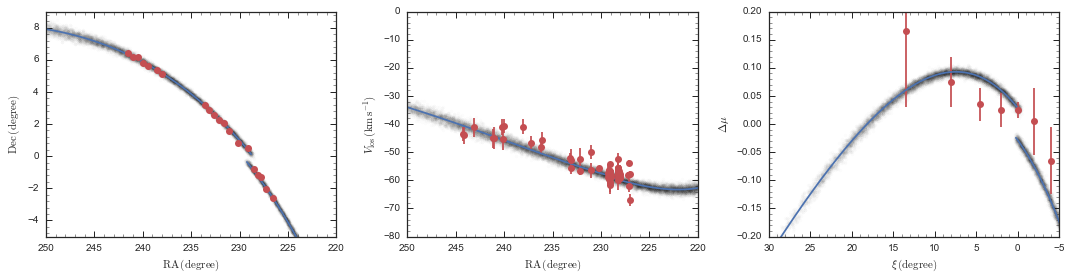

In [101]:
figsize(15,4)
subplot(1,3,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,3,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,3,3)
bovy_plot.bovy_plot(trackxieta_trailing[:,0],
                    5.*numpy.log10(sdf_trailing._interpolatedObsTrackLB[:,2]/23.2),
                    color=sns.color_palette()[0],
                    xrange=[30.,-5.],
                    yrange=[-0.2,0.2],
                    xlabel=r'$\xi\,(\mathrm{degree})$',
                    ylabel=r'$\Delta \mu$',
                   gcf=True)
bovy_plot.bovy_plot(trackxieta_leading[:,0],
                    5.*numpy.log10(sdf_leading._interpolatedObsTrackLB[:,2]/23.2),
                    color=sns.color_palette()[0],
                    overplot=True)
plot(xieta_sample_trailing[:,0],5.*numpy.log10(lb_sample_trailing[2]/23.2),'k.',
     alpha=0.01,zorder=0)
plot(xieta_sample_leading[:,0],5.*numpy.log10(lb_sample_leading[2]/23.2),'k.',
     alpha=0.01,zorder=0)
errorbar(dm_xi[:,0],dm_xi[:,1]+0.025,yerr=1.5*dm_xi[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
tight_layout()

(-10.0, 10)

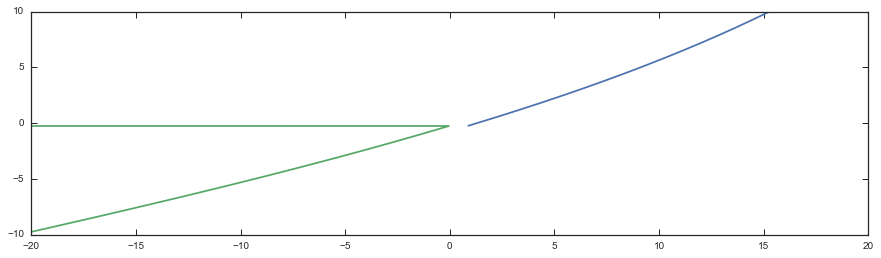

In [72]:
plot(sdf_trailing._interpolatedObsTrackLB[:,0],trackxieta_trailing[:,0])
plot(sdf_leading._interpolatedObsTrackLB[:,0]-360.,trackxieta_leading[:,0])
xlim(-20.,20.)
ylim(-10.,10)

In [21]:
from galpy.potential import TriaxialNFWPotential
pot_flat= [MWPotential2014[0],MWPotential2014[1],TriaxialNFWPotential(a=2.,normalize=.35,c=0.7)]
aAI_flat= actionAngleIsochroneApprox(pot=pot_flat,b=0.8)
sdf_trailing_flat= streamdf(sigv/220.,progenitor=prog,
                           pot=pot_flat,aA=aAI_flat,
                           leading=False,nTrackChunks=11,
                           tdisrupt=5./bovy_conversion.time_in_Gyr(V0,R0),
                           Rnorm=R0,Vnorm=V0,R0=R0,
                           vsun=[-11.1,V0+24.,7.25],
                           custom_transform=pal5_util._TPAL5)

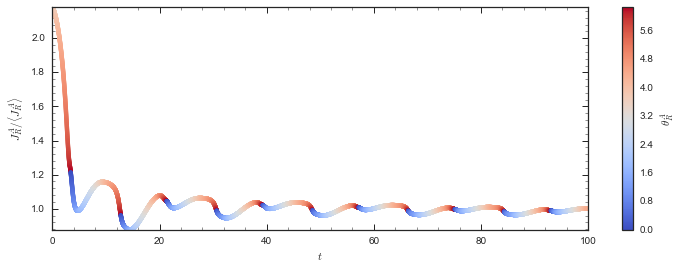

In [24]:
aAI_flat.plot(prog(),type='jr',cmap='coolwarm')

In [25]:
trackRADec_trailing_flat=\
  bovy_coords.lb_to_radec(sdf_trailing_flat._interpolatedObsTrackLB[:,0],
                          sdf_trailing_flat._interpolatedObsTrackLB[:,1],
                          degree=True)

<Container object of 3 artists>

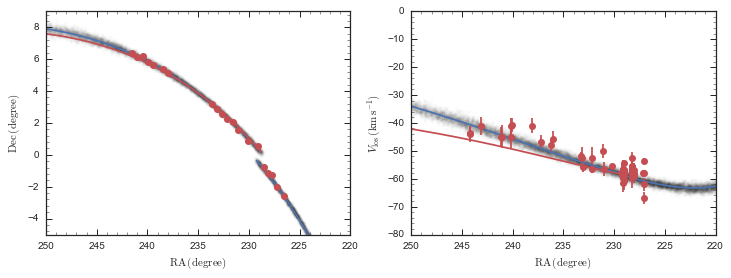

In [26]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
bovy_plot.bovy_plot(trackRADec_trailing_flat[:,0],
                    trackRADec_trailing_flat[:,1],
                    color=sns.color_palette()[2],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
bovy_plot.bovy_plot(trackRADec_trailing_flat[:,0],
                    sdf_trailing_flat._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[2],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

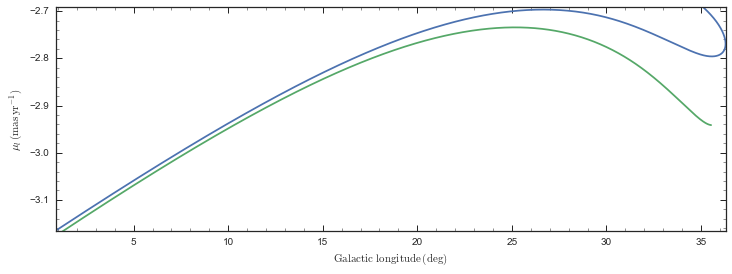

In [31]:
sdf_trailing_flat.plotTrack(d1='ll',d2='pmll')
sdf_trailing.plotTrack(d1='ll',d2='pmll',overplot=True)

In [106]:
print "Physical length: %f kpc (leading,trailing)=(%f,%f) kpc" % \
    (sdf_leading.length(phys=True)+sdf_trailing.length(phys=True),
     sdf_leading.length(phys=True),sdf_trailing.length(phys=True))
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True)+sdf_trailing.length(ang=True),
     sdf_leading.length(ang=True),sdf_trailing.length(ang=True))
print "Angular width (FWHM): %f arcmin" % (2.355*60.*numpy.std(radec_sample_trailing[numpy.fabs(radec_sample_trailing[:,0]-235.) < .05,1]))

Physical length: 31.085421 kpc (leading,trailing)=(18.087126,12.998295) kpc
Angular length: 92.877256 deg (leading,trailing)=(57.348529,35.528727) deg
Angular width (FWHM): 14.050329 arcmin


Also in $(\xi,\eta)$ coordinates

In [9]:
xieta_sample_trailing= pal5_util.radec_to_pal5xieta(radec_sample_trailing[:,0],
                                                   radec_sample_trailing[:,1],
                                                   degree=True)
xieta_sample_leading= pal5_util.radec_to_pal5xieta(radec_sample_leading[:,0],
                                                  radec_sample_leading[:,1],
                                                  degree=True)
trackxieta_trailing=\
  pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],degree=True)
trackxieta_leading=\
  pal5_util.radec_to_pal5xieta(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],degree=True)
pos_xieta= pal5_util.radec_to_pal5xieta(pos_radec[:,0],pos_radec[:,1],
                                        degree=True)

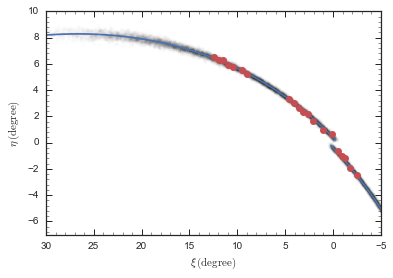

In [10]:
figsize(6,4)
bovy_plot.bovy_plot(trackxieta_trailing[:,0],
                    trackxieta_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[30.,-5.],
                    yrange=[-7.,10.],
                    xlabel=r'$\xi\,(\mathrm{degree})$',
                    ylabel=r'$\eta\,(\mathrm{degree})$')
bovy_plot.bovy_plot(trackxieta_leading[:,0],
                    trackxieta_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(xieta_sample_trailing[:,0],xieta_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(xieta_sample_leading[:,0],xieta_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
plot(pos_xieta[:,0],pos_xieta[:,1],
        ls='none',marker='o',color=sns.color_palette()[2])

Density in $(\xi,\eta)$ coordinates:

(-15.0, 40)

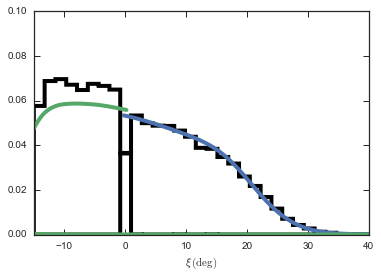

In [11]:
dens_xi= numpy.array([sdf_trailing.density_par(x,coord='customra') for x in sdf_trailing._interpolatedThetasTrack])
plot(trackxieta_trailing[:,0],
     dens_xi/numpy.sum(dens_xi*(
     numpy.roll(trackxieta_trailing[:,0],-1)-trackxieta_trailing[:,0])),lw=4.)
dum= hist(xieta_sample_trailing[:,0],range=[-15.,40.],bins=31,normed=True,histtype='step',lw=4.,color='k')
dens_xi= numpy.array([sdf_leading.density_par(x,coord='customra') for x in sdf_leading._interpolatedThetasTrack])
plot(trackxieta_leading[:,0],
     -dens_xi/numpy.sum(dens_xi*(
     numpy.roll(trackxieta_leading[:,0],-1)-trackxieta_leading[:,0])),lw=4.)
dum= hist(xieta_sample_leading[:,0],range=[-15.,40.],bins=31,normed=True,histtype='step',lw=4.,color='k')
xlabel(r'$\xi\,(\mathrm{deg})$')
ylim(0.,0.1)
xlim(-15.,40)

## Number of subhalo encounters expected (preliminary investigation)

In [12]:
def nsubhalo(m):
    return 0.3*(10.**6.5/m)
def bmax(m):
    return 0.075*(m/10.**6.5)**0.5

In [13]:
ms= 10.**(numpy.linspace(4.,9.,201))
def dNencdm(m):
    return sdf_trailing.subhalo_encounters(sigma=120./220.,nsubhalo=nsubhalo(m),
                                                      bmax=bmax(m))\
           +sdf_leading.subhalo_encounters(sigma=120./220.,nsubhalo=nsubhalo(m),
                                                      bmax=bmax(m))
dndm= numpy.array([dNencdm(m) for m in ms])

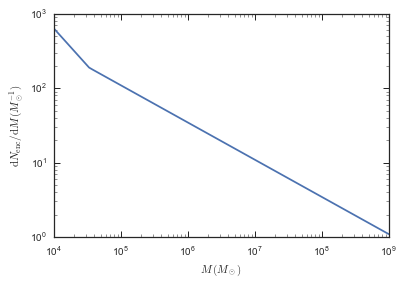

In [14]:
loglog(ms,dndm)
xlabel(r'$M\,(M_\odot)$')
ylabel(r'$\mathrm{d} N_\mathrm{enc} / \mathrm{d} M\,(M^{-1}_\odot)$')

In [15]:
print "Pal 5 should have %f encounters with subhalos more massive than 10^5 Msolar over its lifetime" \
    % (dNencdm(10.**5.5)+dNencdm(10.**6.5)+dNencdm(10.**7.5)+dNencdm(10.**8.5)+dNencdm(10.**9.5))
print "Pal 5 should have %f encounters with subhalos more massive than 10^6 Msolar over its lifetime" \
    % (dNencdm(10.**6.5)+dNencdm(10.**7.5)+dNencdm(10.**8.5)+dNencdm(10.**9.5))
print "Pal 5 should have %f encounters with subhalos more massive than 10^7 Msolar over its lifetime" \
    % (dNencdm(10.**7.5)+dNencdm(10.**8.5)+dNencdm(10.**9.5))
print "Pal 5 should have %f encounters with subhalos more massive than 10^8 Msolar over its lifetime" \
    % (dNencdm(10.**8.5)+dNencdm(10.**9.5))

Pal 5 should have 89.518953 encounters with subhalos more massive than 10^5 Msolar over its lifetime
Pal 5 should have 28.114200 encounters with subhalos more massive than 10^6 Msolar over its lifetime
Pal 5 should have 8.696312 encounters with subhalos more massive than 10^7 Msolar over its lifetime
Pal 5 should have 2.555836 encounters with subhalos more massive than 10^8 Msolar over its lifetime
